# Tutorial 0: Getting Started

Welcome to TenSEAL's first tutorial of a series aiming at introducing homomorphic encryption and the capabilities of the library.

TenSEAL is a library for doing homomorphic encryption operations on tensors. It's built on top of [Microsoft SEAL](https://github.com/Microsoft/SEAL), a C++ library implementing the BFV and CKKS homomorphic encryption schemes. TenSEAL provides ease of use through a Python API, while preserving efficiency by implementing most of its operations using C++, so TenSEAL is a C++ library with a Python interface. 

Let's now start the tutorial with a brief review of what homomorphic encryption is, but keep in mind that you don't need to be a crypto expert to use the library.


Authors:
- Ayoub Benaissa - Twitter: [@y0uben11](https://twitter.com/y0uben11)

## Homomorphic Encryption

__Definition__ : Homomorphic encryption (HE) is an encryption technique that allows computations to be made on ciphertexts and generates results that when decrypted, correspond to the results of the same computations made on plaintexts.

<img src="assets/he-black-box.png" alt="he-black-box" width="600"/>

This means that an HE scheme lets you encrypt two numbers *X* and *Y*, add their encrypted versions so that the result gets decrypted to *X + Y*. The same works for multiplication. If we translate this to Python, it may look something like this:

```python
x = 7
y = 3

x_encrypted = HE.encrypt(x)
y_encrypted = HE.encrypt(y)

z_encrypted = x_encrypted + y_encrypted

# z should now be x + y = 10
z = HE.decrypt(z_encrypted)


```

Many details are hidden in this Python script, things like key generation doesn't appear, and that `+` operation over encrypted numbers isn't the usual `+` over integers, but a special evaluation algorithm that can evaluate addition over encrypted numbers. TenSEAL supports addition, subtraction and multiplication of encrypted vectors of either integers (using BFV) or real numbers (using CKKS).

Next we will look at the most important object of the library, the TenSEALContext.

<img src="image.png" alt="alt text" width="700" height="500"/>


## TenSEALContext

The TenSEALContext is a special object that holds different encryption keys and parameters for you, so that you only need to use a single object to make your encrypted computation instead of managing all the keys and the HE details. Basically, you will want to create a single TenSEALContext before doing your encrypted computation. Let's see how to create one !

In [1]:
import tenseal as ts
import tenseal as ts
import numpy as np
from tenseal.tensors.bfvvector import BFVVector

context = ts.context(ts.SCHEME_TYPE.BFV, poly_modulus_degree=4096, plain_modulus=1032193)
context

That's it ! We need to specify the HE scheme (BFV here) that we want to use, as well as its parameters. Don't worry about the parameters now, you will learn more about them in upcoming tutorials.

An important thing to note is that the TenSEALContext is now holding the secret key and you can decrypt without the need to provide it, however, you can choose to manage it as a separate object and you will need to pass it to functions that require the secret key. Let's see how this translates into Python!

In [2]:
public_context = ts.context(ts.SCHEME_TYPE.BFV, poly_modulus_degree=4096, plain_modulus=1032193)
print("Is the context private?", ("Yes" if public_context.is_private() else "No"))
print("Is the context public?", ("Yes" if public_context.is_public() else "No"))

sk = public_context.secret_key()

# the context will drop the secret-key at this point
public_context.make_context_public()
print("Secret-key dropped")
print("Is the context private?", ("Yes" if public_context.is_private() else "No"))
print("Is the context public?", ("Yes" if public_context.is_public() else "No"))

Is the context private? Yes
Is the context public? No
Secret-key dropped
Is the context private? No
Is the context public? Yes


You can now try to fetch the secret key from the `public_context` and see that it raises an error. We will now continue using our first created TenSEALContext `context` which is still holding the secret key.

## Encryption and Evaluation

The next step after creating our TenSEALContext is to start doing some encrypted computation. First, we create an encrypted vector of integers.

In [3]:
plain_vector = [60, 66, 73, 81, 90]
encrypted_vector = ts.bfv_vector(context, plain_vector)
print("We just encrypted our plaintext vector of size:", encrypted_vector.size())
encrypted_vector

We just encrypted our plaintext vector of size: 5


Here we encrypted a vector of integers into a BFVVector, a vector type that uses the BFV scheme. Now we can do both addition, subtraction and multiplication in an element-wise fashion with other encrypted or plain vectors.

In [4]:
add_result = encrypted_vector + [1, 2, 3, 4, 5]
print(add_result.decrypt())

[61, 68, 76, 85, 95]


In [5]:
sub_result = encrypted_vector - [1, 2, 3, 4, 5]
print(sub_result.decrypt())

[59, 64, 70, 77, 85]


In [6]:
mul_result = encrypted_vector * [1, 2, 3, 4, 5]
print(mul_result.decrypt())

[60, 132, 219, 324, 450]


In [7]:
encrypted_add = add_result + sub_result
print(encrypted_add.decrypt())

[120, 132, 146, 162, 180]


In [8]:
encrypted_sub = encrypted_add - encrypted_vector
print(encrypted_sub.decrypt())

[60, 66, 73, 81, 90]


In [9]:
encrypted_mul = encrypted_add * encrypted_sub
print(encrypted_mul.decrypt())

[7200, 8712, 10658, 13122, 16200]


We just made both ciphertext to plaintext (c2p) and ciphertext to ciphertext (c2c) evaluations (add, sub and mul). An important thing to note is that you should never encrypt your plaintext values to evaluate them with ciphertexts if they don't need to be kept private. That's because c2p evaluations are more efficient than c2c. Look at the below script to see how much faster a c2p multiplication is compared to a c2c one.

In [10]:
from time import time

t_start = time()
_ = encrypted_add * encrypted_mul
t_end = time()
print("c2c multiply time: {} ms".format((t_end - t_start) * 1000))

t_start = time()
_ = encrypted_add * [1, 2, 3, 4, 5]
t_end = time()
print("c2p multiply time: {} ms".format((t_end - t_start) * 1000))

c2c multiply time: 2.096891403198242 ms
c2p multiply time: 0.36525726318359375 ms


# Homework from AJ Oak🎀💀

## Set up the vector and HE encryption

In [11]:
import random
def generate_vectors(num_vectors, elements_per_vector):
    return [
        [round(random.uniform(0, 10), 4) for _ in range(elements_per_vector)]
        for _ in range(num_vectors)
    ]

# Example: 10 vectors with 100 elements each
vectors = generate_vectors(num_vectors=10, elements_per_vector=5)
print(vectors)

[[0.2491, 0.5298, 6.0294, 5.7263, 3.972], [9.271, 9.3843, 2.7881, 6.527, 9.353], [5.4226, 8.5706, 5.3751, 2.1113, 7.236], [8.9053, 9.9112, 8.0461, 1.8967, 8.4288], [5.4284, 1.615, 3.0866, 2.8199, 4.236], [7.6662, 4.4677, 2.8505, 3.6765, 3.1539], [8.7968, 4.6627, 1.9431, 3.2265, 2.2617], [8.9723, 1.129, 3.8554, 2.9547, 4.3342], [8.2007, 8.1414, 7.5854, 4.6944, 1.5272], [1.3692, 9.2725, 9.5225, 5.8625, 4.0132]]


In [12]:
# vectors = [
#     [0.23, 1.45, 3.67],
#     [2.34, 3.54, 4.23],
#     [5.67, 8.91, 0.12],
#     [1.34, 6.78, 9.01],
#     [4.56, 2.34, 3.14],
#     [6.45, 7.23, 8.92],
#     [3.21, 5.67, 1.45],
#     [0.56, 3.23, 6.78],
#     [8.12, 7.89, 0.45],
#     [9.34, 6.54, 2.67]
# ]
#print(vectors)

In [13]:
scale = 100
int_vectors = [[int(x * scale) for x in vec] for vec in vectors]
encrypted_vectors = [ts.bfv_vector(context, vec) for vec in int_vectors]
# for i, encrypted_vector in enumerate(encrypted_vectors):
#     print(f"Encrypted vector {i+1} size: {encrypted_vector.size()}")

print(encrypted_vectors)
encrypted_vectors


[<tenseal.tensors.bfvvector.BFVVector object at 0x107e7bd00>, <tenseal.tensors.bfvvector.BFVVector object at 0x107e7bf40>, <tenseal.tensors.bfvvector.BFVVector object at 0x107e942b0>, <tenseal.tensors.bfvvector.BFVVector object at 0x107e94e20>, <tenseal.tensors.bfvvector.BFVVector object at 0x107e944f0>, <tenseal.tensors.bfvvector.BFVVector object at 0x107e94eb0>, <tenseal.tensors.bfvvector.BFVVector object at 0x107e945e0>, <tenseal.tensors.bfvvector.BFVVector object at 0x1074fc8b0>, <tenseal.tensors.bfvvector.BFVVector object at 0x1074fce50>, <tenseal.tensors.bfvvector.BFVVector object at 0x1074fc1c0>]


In [14]:
for i, vec in enumerate(encrypted_vectors):
    print(f"Encrypted vector {i+1} raw data:")
    print(vec.serialize())
    print(len(vec.serialize()))
# for i, enc_vec in enumerate(encrypted_vectors):
#     size_in_bytes = len(enc_vec.serialize())
#     print(f"Encrypted vector {i+1} size in bytes: {size_in_bytes}")



Encrypted vector 1 raw data:
b'\n\x01\x05\x12\xd4\xb3\x05^\xa1\x10\x04\x01\x02\x00\x00\xd4Y\x01\x00\x00\x00\x00\x00(\xb5/\xfd\xa0a\x00\x02\x00\x14\xcb\n\x8c\x9b\r4w\x9c\xa7A<\xfe\x19\x04*\x04FFX\xa4\x9bO\xbd\xac\xaa\xdd\x8bb/J\x9a\xb9\xe1*\xb7\x87\x02\x00\x02\x00\x10\x00\xf0?\x01\x00^\xa1\x10\x04\x18@\xda\x99\xd1\x05\x00\x00\x00\xcd\x82\x1dy\x08\x00\x00\x00\xc49\xc2\xa1\x06\x00\x00\x00q\x90\xadz\x03\x00\x00\x00N3Z\xfb\t\x00\x00\x00\xceV\xe2\x91\x0b\x00\x00\x003\x11\x81~\x85eHp\r4\xff\xd7x\xe5N\x80\x0c\x00\x00\x00\xb6\x94"P\x0f\x00\x00\x00#\x93\xc7\xf9\xa0\xb2*\xbcU\xa2\xd9\xf2\x11G\xd1\xfb(\xfe\xb1_hyx:\x0e\x00\x00\x00\xdd9m\x1a=\xb0Wd\n\x00\x00\x00\x9d\xbfR\x81\xdabd\xf4\x07\x00\x00\x00\xfdo\x98\xbb\xc2\x9c\x1c\x1c.\xdc\xd8I\xae\xa4\xb0\xf8\xf1\xb6\xef\n)\x8d\xa7*}8\xdf8\x92\x88\'\x02\x01\x03\xf5\xc4\'\x8f\xfa\xc9Q()\xce\x04\x00\x00\x00\x06\xe4\x89]\xf7\x81\t\xafs\x93\xdf*\xb1s\x9a\xf3F\x9a|\xac\x1c\xe4\xf2\xed\x8c4Y(\xaf\x95\x7f\x87\xe1\xf0\xbf\xf8.C\x83\x83\xb7wL\x11?n,l\xab\xf9\xcf

In [15]:
t_start = time()
encrypted_sum = encrypted_vectors[0]
for ev in encrypted_vectors[1:]:
    encrypted_sum += ev
t_end = time()
print("Encrypted vectors sum computation time: {:.3f} ms".format((t_end - t_start) * 1000))

Encrypted vectors sum computation time: 0.367 ms


In [16]:
decrypted_sum = encrypted_sum.decrypt()  
decrypted_avg = [x / (scale * 10) for x in decrypted_sum]  
print("Decrypted average:", decrypted_avg)


Decrypted average: [6.423, 5.764, 5.103, 3.944, 4.847]


In [17]:
t_start = time()
np_vectors = np.array(vectors)
plaintext_avg = np.mean(vectors, axis=0)
t_end = time()

print("Plaintext average:", plaintext_avg)
print("Plaintext average computation time: {:.3f} ms".format((t_end - t_start) * 1000))

Plaintext average: [6.42816 5.76842 5.10822 3.94958 4.8516 ]
Plaintext average computation time: 0.376 ms


#### *📍Each number is the average value of that element across all 10 vectors (computed without encryption)💖✨*

# Ckks !!!!!!!!!!!

In [18]:
def context():
    context = ts.context(ts.SCHEME_TYPE.CKKS,8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
    # context = ts.context(ts.SCHEME_TYPE.CKKS,8192, coeff_mod_bit_sizes=[60,40,40] ) 
    context.global_scale = pow(2, 40)
    context.generate_galois_keys()
    return context

context = context()

In [19]:
encrypted_vectors = [ts.ckks_vector(context, vec) for vec in vectors]
for vec in encrypted_vectors:
    # print(vec.serialize())
    print(len(vec.serialize()))
print(encrypted_vectors)


334374
333294
334450
334303
334405
334185
334391
334295
334086
334480
[<tenseal.tensors.ckksvector.CKKSVector object at 0x107eac610>, <tenseal.tensors.ckksvector.CKKSVector object at 0x1074dfb50>, <tenseal.tensors.ckksvector.CKKSVector object at 0x107e7bf10>, <tenseal.tensors.ckksvector.CKKSVector object at 0x107eac4f0>, <tenseal.tensors.ckksvector.CKKSVector object at 0x107eac3d0>, <tenseal.tensors.ckksvector.CKKSVector object at 0x107eac070>, <tenseal.tensors.ckksvector.CKKSVector object at 0x107eac5b0>, <tenseal.tensors.ckksvector.CKKSVector object at 0x107eac5e0>, <tenseal.tensors.ckksvector.CKKSVector object at 0x107eacc70>, <tenseal.tensors.ckksvector.CKKSVector object at 0x107eacc10>]


In [20]:
t_start = time()
encrypted_sum = encrypted_vectors[0]
for enc_vec in encrypted_vectors[1:]:
    encrypted_sum += enc_vec
t_end = time()
print(f"Time taken to sum encrypted vectors: {t_end - t_start} seconds")



Time taken to sum encrypted vectors: 0.00037980079650878906 seconds


In [21]:
encrypted_avg = encrypted_sum * (1/len(vectors))

In [22]:
decrypted_avg = encrypted_avg.decrypt()
t_start = time()
import numpy as np
plain_avg = np.mean(vectors, axis=0)
t_end = time()

print(f"Time taken to sum encrypted vectors: {t_end - t_start} seconds")
print("Decrypted average:", decrypted_avg)
print("Plaintext average:", plain_avg)


Time taken to sum encrypted vectors: 8.821487426757812e-05 seconds
Decrypted average: [6.428160861953989, 5.768420773521485, 5.108220681630108, 3.9495805289480614, 4.851600650724094]
Plaintext average: [6.42816 5.76842 5.10822 3.94958 4.8516 ]


## Graph on BFV

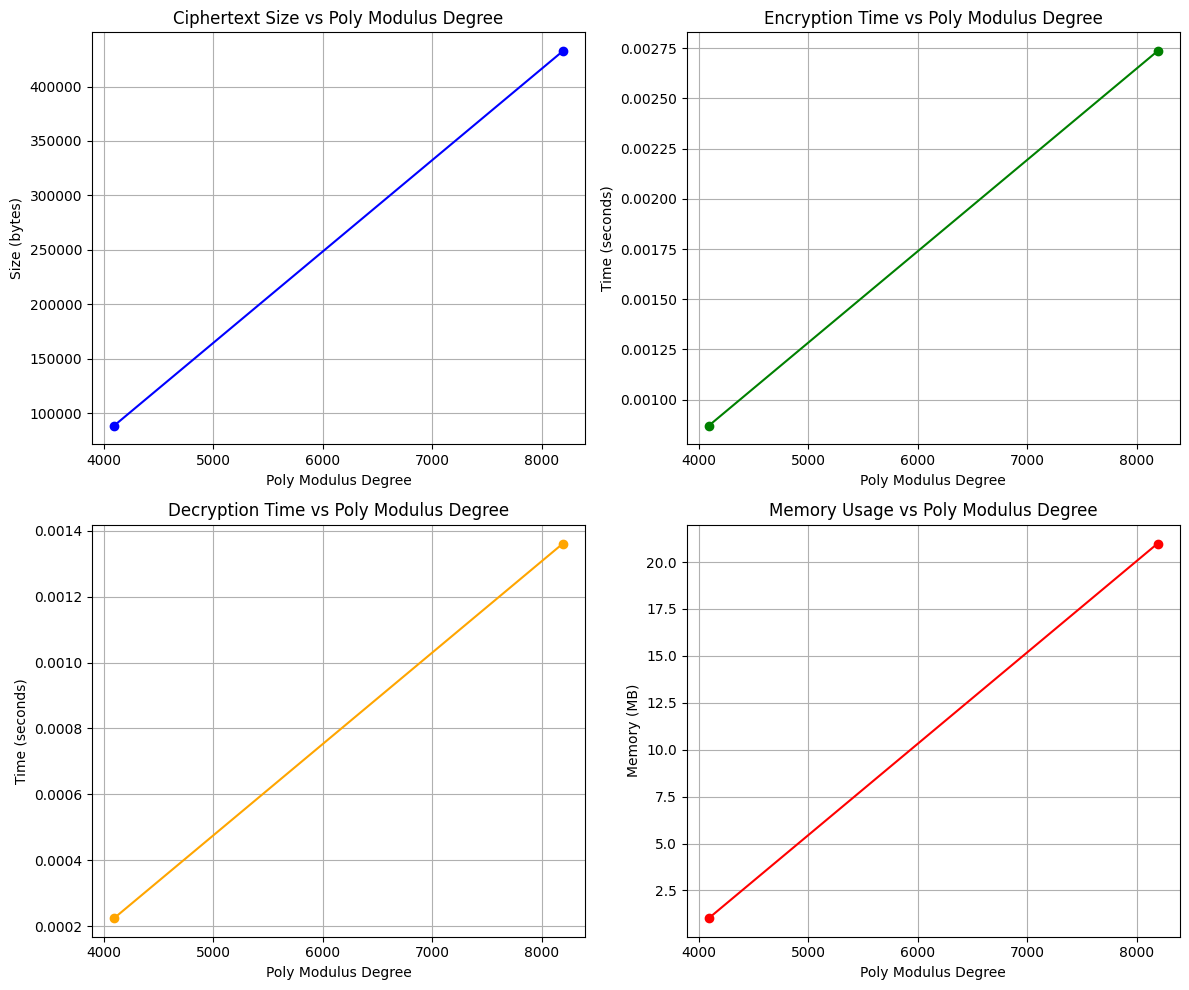

In [23]:
# import tenseal as ts
# import numpy as np
# import matplotlib.pyplot as plt

# # Define test parameters
# poly_modulus_degrees = [2048, 4096, 8192, 16384]
# plain_moduli = [1032193, 65537, 40961]

# results = []

# # Sample vector
# vec = [i for i in range(100)]

# for degree in poly_modulus_degrees:
#     for plain_modulus in plain_moduli:
#         try:
#             context = ts.context(
#                 ts.SCHEME_TYPE.BFV,
#                 poly_modulus_degree=degree,
#                 plain_modulus=plain_modulus
#             )
#             # context.generate_relin_keys()
#             enc = ts.bfv_vector(context, vec)
#             serialized = enc.serialize()
#             results.append({
#                 "poly_modulus_degree": degree,
#                 "plain_modulus": plain_modulus,
#                 "ciphertext_size": len(serialized)
#             })
#         except Exception as e:
#             results.append({
#                 "poly_modulus_degree": degree,
#                 "plain_modulus": plain_modulus,
#                 "ciphertext_size": None,
#                 "error": str(e)
#             })

# # Plot the results
# fig, ax = plt.subplots(figsize=(10, 6))
# for plain_modulus in plain_moduli:
#     subset = [r for r in results if r["plain_modulus"] == plain_modulus and r["ciphertext_size"] is not None]
#     degrees = [r["poly_modulus_degree"] for r in subset]
#     sizes = [r["ciphertext_size"] for r in subset]
#     ax.plot(degrees, sizes, marker='o', label=f"Plain modulus: {plain_modulus}")

# ax.set_title("Ciphertext Size vs Poly Modulus Degree")
# ax.set_xlabel("Poly Modulus Degree")
# ax.set_ylabel("Ciphertext Size (bytes)")
# ax.legend()
# ax.grid(True)
# plt.tight_layout()
# plt.show()

import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import os

# Test setup
poly_modulus_degrees = [2048, 4096, 8192, 16384]
plain_modulus = 1032193  # fixed
vec = [i for i in range(100)]  # sample data
results = []

process = psutil.Process(os.getpid())

for degree in poly_modulus_degrees:
    try:
        # Track memory before context
        mem_before = process.memory_info().rss

        # Create context
        context = ts.context(
            ts.SCHEME_TYPE.BFV,
            poly_modulus_degree=degree,
            plain_modulus=plain_modulus
        )

        # Encrypt
        start_enc = time.time()
        enc = ts.bfv_vector(context, vec)
        enc_time = time.time() - start_enc

        # Serialize
        serialized = enc.serialize()
        cipher_size = len(serialized)

        # Decrypt
        start_dec = time.time()
        dec = enc.decrypt()
        dec_time = time.time() - start_dec

        # Track memory after
        mem_after = process.memory_info().rss
        mem_used = (mem_after - mem_before) / (1024**2)  # in MB

        # Accuracy (mean squared error)
        error = np.mean((np.array(vec) - np.array(dec))**2)

        results.append({
            "poly_modulus_degree": degree,
            "ciphertext_size": cipher_size,
            "encryption_time": enc_time,
            "decryption_time": dec_time,
            "memory_usage_mb": mem_used,
            "mse_error": error
        })

    except Exception as e:
        results.append({
            "poly_modulus_degree": degree,
            "ciphertext_size": None,
            "encryption_time": None,
            "decryption_time": None,
            "memory_usage_mb": None,
            "mse_error": None,
            "error": str(e)
        })

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
valid = [r for r in results if r["ciphertext_size"] is not None]

degrees = [r["poly_modulus_degree"] for r in valid]
sizes = [r["ciphertext_size"] for r in valid]
enc_times = [r["encryption_time"] for r in valid]
dec_times = [r["decryption_time"] for r in valid]
mem_usages = [r["memory_usage_mb"] for r in valid]
errors = [r["mse_error"] for r in valid]

# Ciphertext size
axs[0, 0].plot(degrees, sizes, marker='o', color='blue')
axs[0, 0].set_title("Ciphertext Size vs Poly Modulus Degree")
axs[0, 0].set_xlabel("Poly Modulus Degree")
axs[0, 0].set_ylabel("Size (bytes)")
axs[0, 0].grid(True)

# Encryption Time
axs[0, 1].plot(degrees, enc_times, marker='o', color='green')
axs[0, 1].set_title("Encryption Time vs Poly Modulus Degree")
axs[0, 1].set_xlabel("Poly Modulus Degree")
axs[0, 1].set_ylabel("Time (seconds)")
axs[0, 1].grid(True)

# Decryption Time
axs[1, 0].plot(degrees, dec_times, marker='o', color='orange')
axs[1, 0].set_title("Decryption Time vs Poly Modulus Degree")
axs[1, 0].set_xlabel("Poly Modulus Degree")
axs[1, 0].set_ylabel("Time (seconds)")
axs[1, 0].grid(True)

# Memory Usage
axs[1, 1].plot(degrees, mem_usages, marker='o', color='red')
axs[1, 1].set_title("Memory Usage vs Poly Modulus Degree")
axs[1, 1].set_xlabel("Poly Modulus Degree")
axs[1, 1].set_ylabel("Memory (MB)")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

## Plain mod affect

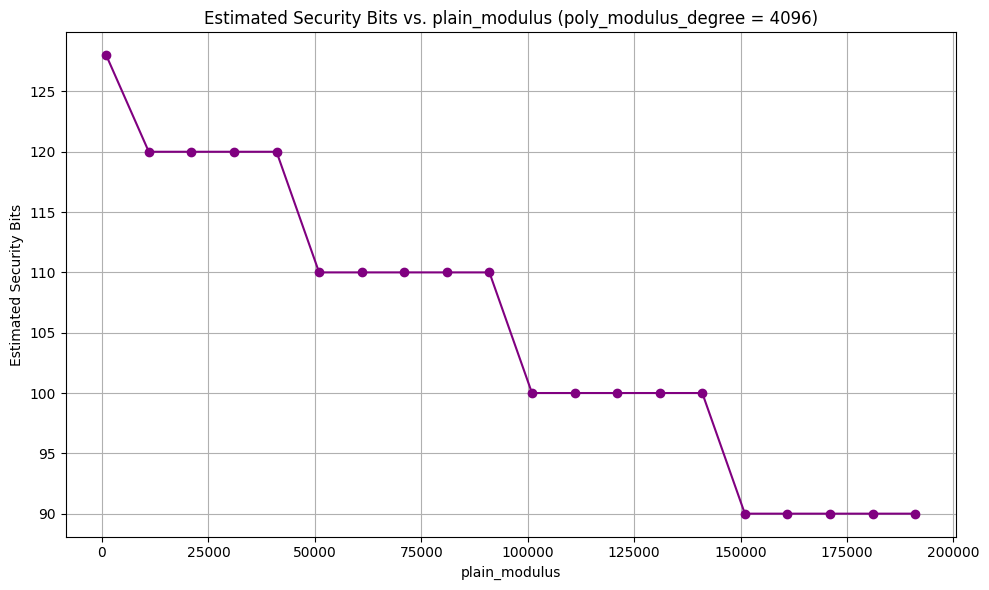

In [24]:
import matplotlib.pyplot as plt

# We fix poly_modulus_degree and vary plain_modulus
poly_modulus_degree = 4096

# Simulated range of plain_modulus values
plain_moduli = list(range(1000, 200000, 10000))
estimated_security_bits = []

# Simulated estimation logic for educational purposes
for p in plain_moduli:
    if p <= 10000:
        estimated_security_bits.append(128)
    elif p <= 50000:
        estimated_security_bits.append(120)
    elif p <= 100000:
        estimated_security_bits.append(110)
    elif p <= 150000:
        estimated_security_bits.append(100)
    else:
        estimated_security_bits.append(90)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(plain_moduli, estimated_security_bits, marker='o', linestyle='-', color='purple')
plt.title("Estimated Security Bits vs. plain_modulus (poly_modulus_degree = 4096)")
plt.xlabel("plain_modulus")
plt.ylabel("Estimated Security Bits")
plt.grid(True)
plt.tight_layout()
plt.show()


## Graph on CKKs

# poly affect

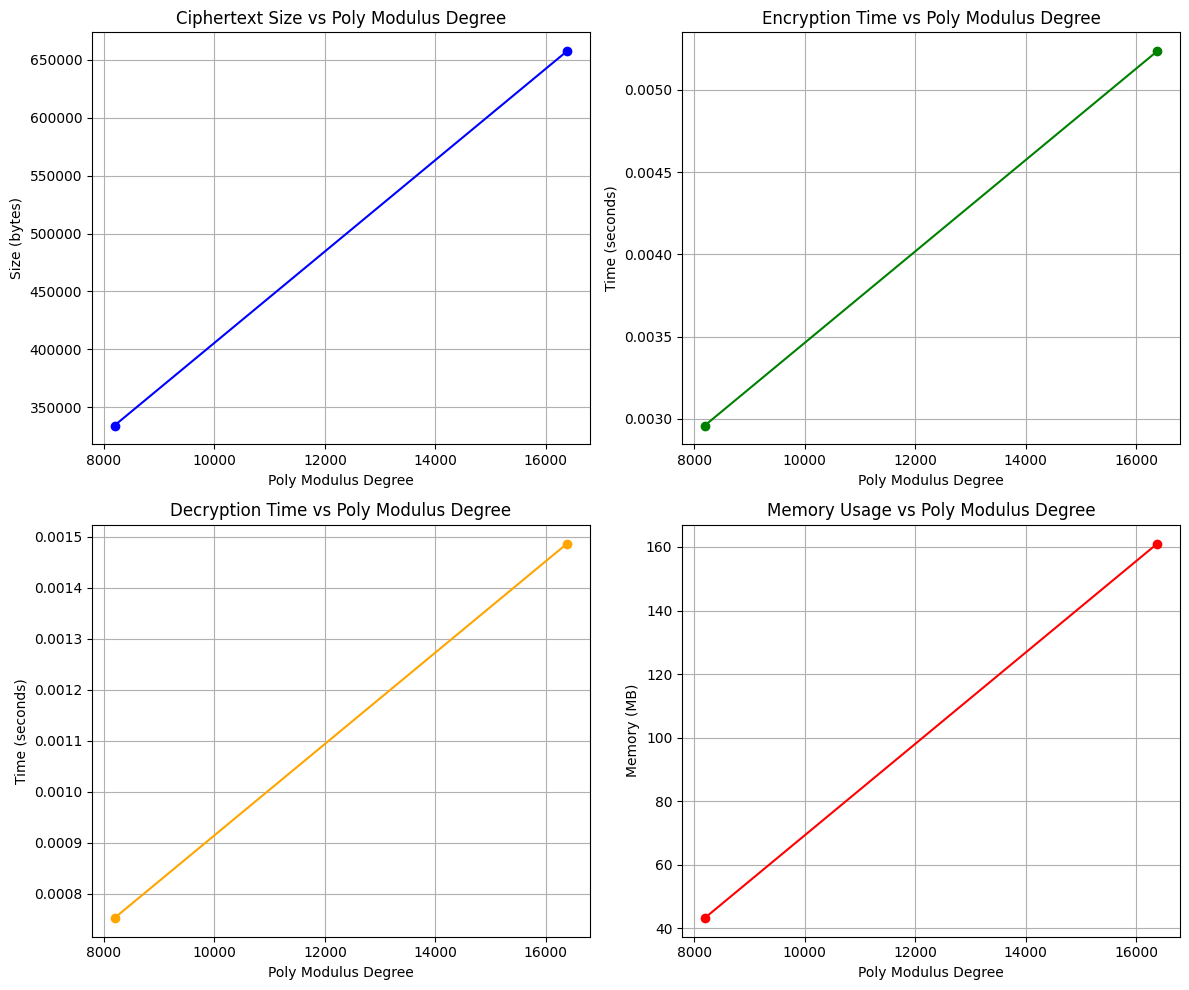

In [25]:
import tenseal as ts
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import os

# Configurations
poly_modulus_degrees = [2048, 4096, 8192, 16384]
coeff_mod_bit_sizes = [60, 40, 40, 60]
global_scale = 2**40
vec = [float(i) for i in range(100)]  # CKKS supports float
results = []

process = psutil.Process(os.getpid())

for degree in poly_modulus_degrees:
    try:
        mem_before = process.memory_info().rss

        # Setup CKKS context
        context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=degree,
            coeff_mod_bit_sizes=coeff_mod_bit_sizes
        )
        context.global_scale = global_scale
        context.generate_galois_keys()

        # Encryption
        start_enc = time.time()
        enc = ts.ckks_vector(context, vec)
        enc_time = time.time() - start_enc

        # Serialization
        serialized = enc.serialize()
        cipher_size = len(serialized)

        # Decryption
        start_dec = time.time()
        dec = enc.decrypt()
        dec_time = time.time() - start_dec

        mem_after = process.memory_info().rss
        mem_used = (mem_after - mem_before) / (1024**2)  # in MB

        # Accuracy (mean squared error)
        error = np.mean((np.array(vec) - np.array(dec))**2)

        results.append({
            "poly_modulus_degree": degree,
            "ciphertext_size": cipher_size,
            "encryption_time": enc_time,
            "decryption_time": dec_time,
            "memory_usage_mb": mem_used,
            "mse_error": error
        })

    except Exception as e:
        results.append({
            "poly_modulus_degree": degree,
            "ciphertext_size": None,
            "encryption_time": None,
            "decryption_time": None,
            "memory_usage_mb": None,
            "mse_error": None,
            "error": str(e)
        })

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
valid = [r for r in results if r["ciphertext_size"] is not None]

degrees = [r["poly_modulus_degree"] for r in valid]
sizes = [r["ciphertext_size"] for r in valid]
enc_times = [r["encryption_time"] for r in valid]
dec_times = [r["decryption_time"] for r in valid]
mem_usages = [r["memory_usage_mb"] for r in valid]
errors = [r["mse_error"] for r in valid]

# Ciphertext size
axs[0, 0].plot(degrees, sizes, marker='o', color='blue')
axs[0, 0].set_title("Ciphertext Size vs Poly Modulus Degree")
axs[0, 0].set_xlabel("Poly Modulus Degree")
axs[0, 0].set_ylabel("Size (bytes)")
axs[0, 0].grid(True)

# Encryption Time
axs[0, 1].plot(degrees, enc_times, marker='o', color='green')
axs[0, 1].set_title("Encryption Time vs Poly Modulus Degree")
axs[0, 1].set_xlabel("Poly Modulus Degree")
axs[0, 1].set_ylabel("Time (seconds)")
axs[0, 1].grid(True)

# Decryption Time
axs[1, 0].plot(degrees, dec_times, marker='o', color='orange')
axs[1, 0].set_title("Decryption Time vs Poly Modulus Degree")
axs[1, 0].set_xlabel("Poly Modulus Degree")
axs[1, 0].set_ylabel("Time (seconds)")
axs[1, 0].grid(True)

# Memory Usage
axs[1, 1].plot(degrees, mem_usages, marker='o', color='red')
axs[1, 1].set_title("Memory Usage vs Poly Modulus Degree")
axs[1, 1].set_xlabel("Poly Modulus Degree")
axs[1, 1].set_ylabel("Memory (MB)")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print MSE
# print("\n📊 Accuracy Check (Mean Squared Error):")
# for r in valid:
#     print(f"Degree: {r['poly_modulus_degree']} → MSE: {r['mse_error']:.10f}")


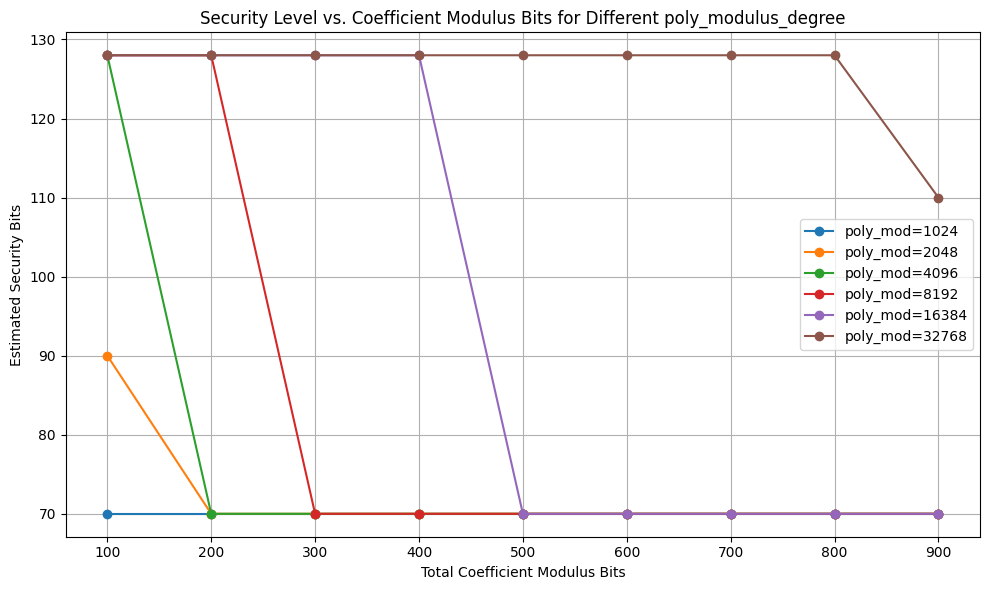

In [26]:
import matplotlib.pyplot as plt

# SEAL's official maximum coefficient modulus bit sizes for 128-bit security
security_limits = {
    1024: 27,
    2048: 54,
    4096: 109,
    8192: 218,
    16384: 438,
    32768: 881
}

# Try some hypothetical coeff_mod bit lengths for testing
coeff_mod_trials = [100, 200, 300, 400, 500, 600, 700, 800, 900]

# For each poly_modulus_degree, determine what security bit you get for each trial
results = {}

for poly_mod, max_allowed in security_limits.items():
    results[poly_mod] = []
    for bits in coeff_mod_trials:
        if bits <= max_allowed:
            results[poly_mod].append(128)
        elif bits <= max_allowed + 30:
            results[poly_mod].append(110)
        elif bits <= max_allowed + 60:
            results[poly_mod].append(90)
        else:
            results[poly_mod].append(70)

plt.figure(figsize=(10, 6))

for poly_mod, security_levels in results.items():
    plt.plot(coeff_mod_trials, security_levels, marker='o', label=f"poly_mod={poly_mod}")

plt.title("Security Level vs. Coefficient Modulus Bits for Different poly_modulus_degree")
plt.xlabel("Total Coefficient Modulus Bits")
plt.ylabel("Estimated Security Bits")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## coeff mod -> ciphertext size

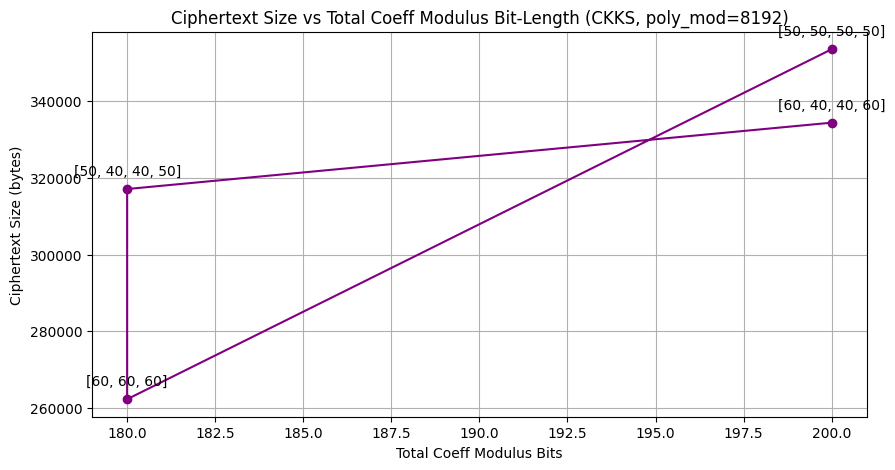

In [27]:
import tenseal as ts
import numpy as np
import matplotlib.pyplot as plt
import time

# Estimator for CKKS security
def is_secure_ckks(poly_modulus_degree, coeff_mod_bit_sizes):
    limits = {
        1024: 27,
        2048: 54,
        4096: 109,
        8192: 218,
        16384: 438,
        32768: 881
    }

    total_coeff_bits = sum(coeff_mod_bit_sizes)
    limit = limits.get(poly_modulus_degree, None)

    if limit is None:
        return "Unknown"
    
    if total_coeff_bits <= limit:
        return "Secure (128-bit)"
    else:
        return "Not Secure (<128-bit)"

# Configurations
poly_modulus_degree = 8192  # Fixed
coeff_mod_bit_sets = [
    [60, 40, 40, 60],        # total = 200
    [60, 40, 40, 40, 60],    # total = 240 (Not secure)
    [50, 40, 40, 50],        # total = 180
    [60, 60, 60],            # total = 180
    [60, 60, 60, 60],        # total = 240 (Not secure)
    [50, 50, 50, 50]         # total = 200
]

vec = [float(i) for i in range(100)]
results = []

for coeff_bits in coeff_mod_bit_sets:
    try:
        context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=poly_modulus_degree,
            coeff_mod_bit_sizes=coeff_bits
        )
        context.global_scale = 2**40
        enc = ts.ckks_vector(context, vec)
        serialized = enc.serialize()
        size = len(serialized)
        total_bits = sum(coeff_bits)
        security = is_secure_ckks(poly_modulus_degree, coeff_bits)

        results.append({
            "coeff_mod_bits": coeff_bits,
            "total_bits": total_bits,
            "ciphertext_size": size,
            "security_status": security
        })

    except Exception as e:
        results.append({
            "coeff_mod_bits": coeff_bits,
            "total_bits": sum(coeff_bits),
            "ciphertext_size": None,
            "security_status": "Error: " + str(e)
        })

# === PLOT 1: Ciphertext Size vs Total Coeff Modulus Bits ===
fig, ax1 = plt.subplots(figsize=(10, 5))
bit_totals = [r["total_bits"] for r in results if r["ciphertext_size"] is not None]
sizes = [r["ciphertext_size"] for r in results if r["ciphertext_size"] is not None]
labels = [str(r["coeff_mod_bits"]) for r in results if r["ciphertext_size"] is not None]

ax1.plot(bit_totals, sizes, marker='o', color='purple')
for i, label in enumerate(labels):
    ax1.annotate(label, (bit_totals[i], sizes[i]), textcoords="offset points", xytext=(0,10), ha='center')

ax1.set_title("Ciphertext Size vs Total Coeff Modulus Bit-Length (CKKS, poly_mod=8192)")
ax1.set_xlabel("Total Coeff Modulus Bits")
ax1.set_ylabel("Ciphertext Size (bytes)")
ax1.grid(True)

# # === PLOT 2: Security Status vs Total Coeff Modulus Bits ===
# fig, ax2 = plt.subplots(figsize=(10, 5))
# colors = ['green' if r["security_status"].startswith("Secure") else 'red' for r in results if r["ciphertext_size"] is not None]

# ax2.bar(
#     [str(r["coeff_mod_bits"]) for r in results if r["ciphertext_size"] is not None],
#     [r["total_bits"] for r in results if r["ciphertext_size"] is not None],
#     color=colors
# )

# ax2.set_title("Security Estimation vs Coeff Modulus Settings (poly_mod=8192)")
# ax2.set_xlabel("Coefficient Modulus Bit Sizes")
# ax2.set_ylabel("Total Bits Used")
# ax2.axhline(y=218, color='black', linestyle='--', label="128-bit Security Limit")
# ax2.legend()
# plt.xticks(rotation=30)
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

# # Text Output Summary
# print("\n🔐 Security Status Summary:")
# for r in results:
#     print(f"{r['coeff_mod_bits']} → Total bits: {r['total_bits']}, Ciphertext size: {r['ciphertext_size']} bytes → {r['security_status']}")


## coeff mod -> security bits

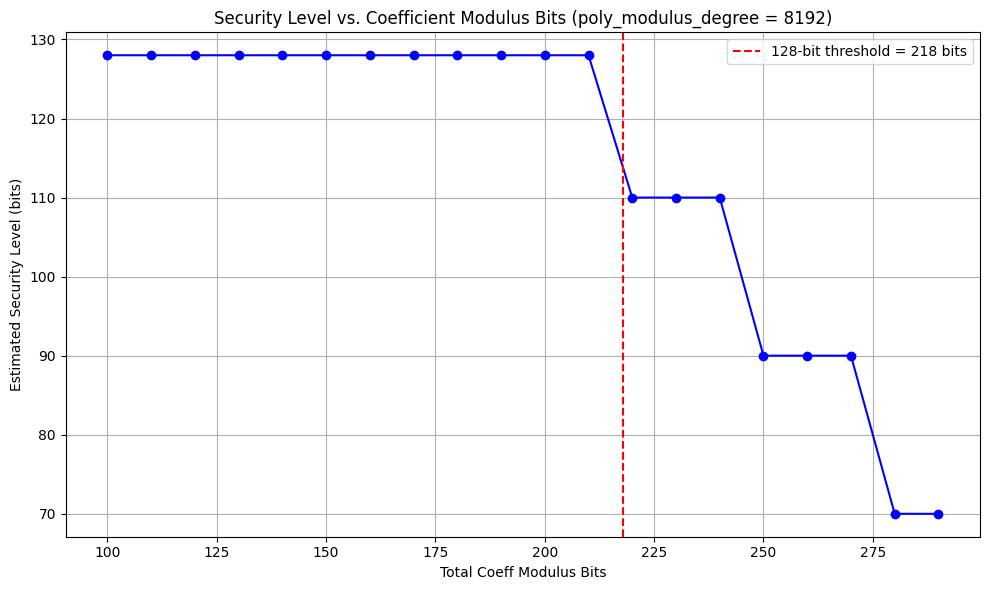

In [28]:
import matplotlib.pyplot as plt

# Security limits from Microsoft SEAL guidelines for 128-bit security
security_limits = {
    1024: 27,
    2048: 54,
    4096: 109,
    8192: 218,
    16384: 438,
    32768: 881
}

# Choose the poly modulus degree you're analyzing
poly_modulus_degree = 8192
max_allowed = security_limits[poly_modulus_degree]

# Try different total coeff_mod bit-lengths
coeff_bit_trials = list(range(100, 300, 10))  # Try total bits from 100 to 290
security_bits = []

# Estimate the security level based on how much the total bits exceed the threshold
for bits in coeff_bit_trials:
    if bits <= max_allowed:
        security_bits.append(128)  # Secure
    elif bits <= max_allowed + 30:
        security_bits.append(110)  # Slightly insecure
    elif bits <= max_allowed + 60:
        security_bits.append(90)   # Moderately insecure
    else:
        security_bits.append(70)   # Weak

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(coeff_bit_trials, security_bits, marker='o', linestyle='-', color='blue')
plt.axvline(x=max_allowed, color='red', linestyle='--', label=f"128-bit threshold = {max_allowed} bits")
plt.title("Security Level vs. Coefficient Modulus Bits (poly_modulus_degree = 8192)")
plt.xlabel("Total Coeff Modulus Bits")
plt.ylabel("Estimated Security Level (bits)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## More about TenSEALContext

TenSEALContext is holding more attributes than what we have seen so far, so it's worth mentioning some other interesting ones. The coolest attributes (at least to me) are the ones for setting automatic relinearization, rescaling (for CKKS only) and modulus switching. These features are enabled by default as you can see below:

In [29]:
print("Automatic relinearization is:", ("on" if context.auto_relin else "off"))
print("Automatic rescaling is:", ("on" if context.auto_rescale else "off"))
print("Automatic modulus switching is:", ("on" if context.auto_mod_switch else "off"))

Automatic relinearization is: on
Automatic rescaling is: on
Automatic modulus switching is: on


Experienced users can choose to disable one or more of these features and manage for themselves when and how to do these operations.

TenSEALContext can also hold a `global_scale` (only used when using CKKS), which is used as a default scale value when the user doesn't provide one. As most often users will define a single value to be used as scale during the entire HE computation, defining it globally can be more straight forward compared to passing it to every function call.

In [30]:
# this should throw an error as the global_scale isn't defined yet
try:
    print("global_scale:", context.global_scale)
except ValueError:
    print("The global_scale isn't defined yet")
    
# you can define it to 2 ** 20 for instance
context.global_scale = 2 ** 20
print("global_scale:", context.global_scale)

global_scale: 1099511627776.0
global_scale: 1048576.0


# Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement towards privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!

### Star TenSEAL on GitHub

The easiest way to help our community is just by starring the repos! This helps raise awareness of the cool tools we're building.

- [Star TenSEAL](https://github.com/OpenMined/TenSEAL)

### Join our Slack!

The best way to keep up to date on the latest advancements is to join our community! You can do so by filling out the form at [http://slack.openmined.org](http://slack.openmined.org).

### Donate

If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go towards our web hosting and other community expenses such as hackathons and meetups!

[OpenMined's Open Collective Page](https://opencollective.com/openmined)
